# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: TC5035.10 Proyecto Integrador**
### Tecnológico de Monterrey
### Dra. Grettel Barceló Alonso 
### Dr. Luis Eduardo Falcón Morales

## **Avance 3. Baseline**


**Nombres y matrículas de los integrantes del equipo:**
| Nombre | Matrícula |
| --- | --- |
| Rodrigo López Aguilera | A01793071 |
| Alejandra Mendoza Flores | A01793032 |
| Diego Carrera Nicholls | A00464290 |

In [20]:
%config Completer.use_jedi = False
# %config InlineBackend.figure_format = 'retina'  # or 'png'
%config InlineBackend.figure_format = 'png'  # or 'png'

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from sklearn.preprocessing import PowerTransformer, RobustScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, learning_curve, LearningCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression



from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

from feature_engine.discretisation import EqualFrequencyDiscretiser

# sns.set_context('notebook')
# sns.set_style('whitegrid')

In [22]:
def learning_curve_plot(train_sizes, train_scores, val_scores, title = None, xlabel = None, ylabel = None):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')

    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')

    if title:
        plt.title(title)

    if xlabel:
        plt.xlabel(xlabel)

    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc='lower left')
    plt.show()

In [23]:
RANDOM_STATE = 42

In [24]:
pd.options.display.float_format = '{:,.2f}'.format

In [25]:
cleaned_df = pd.read_csv('data/pickwin-active-users.csv')

In [26]:
cleaned_df.head()

,days_since_registration,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,churned
0,"2,553.79",1,300.00,0,0.00,1.00,0.00,1.00,300.00,0.00,-300.00,1
1,"2,207.00",1,25.00,0,0.00,2.00,0.00,2.00,30.00,0.00,-30.00,1
2,"2,063.79",1,200.00,0,0.00,14.00,12.00,1.00,200.00,0.00,-200.00,0
3,"2,060.46",1,500.00,0,0.00,1.00,0.00,1.00,500.00,0.00,-500.00,1
4,"2,006.88",3,250.00,0,0.00,9.00,1.00,8.00,320.00,19.39,-300.61,1


In [27]:
cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
days_since_registration,"24,205.00","1,553.90",672.38,30.54,"1,086.79","1,646.12","2,067.92","3,174.88"
purchases_count,"24,205.00",6.92,38.73,1.00,1.00,1.00,3.00,"2,221.00"
purchases_amount,"24,205.00","5,097.34","113,246.83",0.00,100.00,250.00,650.00,"12,664,286.00"
cashouts_count,"24,205.00",0.91,5.64,0.00,0.00,0.00,0.00,228.00
cashouts_amount,"24,205.00","3,907.26","79,872.41",0.00,0.00,0.00,0.00,"8,297,350.00"
total_bets,"23,704.00",62.46,665.34,1.00,2.00,8.00,23.00,"67,543.00"
winning_bets,"23,704.00",15.52,184.26,0.00,0.00,1.00,5.00,"17,863.00"
losing_bets,"23,704.00",46.87,494.65,0.00,2.00,6.00,19.00,"49,680.00"
total_risk,"23,704.00","28,058.01","779,753.11",0.00,186.00,500.00,"1,670.00","65,245,852.00"
total_win,"23,698.00","26,702.06","746,005.16",0.00,0.00,110.61,"1,049.53","63,361,273.78"


In [28]:
clean_df = cleaned_df.drop(columns=['days_since_registration'])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df = clean_df[(clean_df.T != 0).any()]

In [29]:
# feature generation
clean_df['net_winnings'] = clean_df.apply(lambda x: x['net_win'] if x['net_win'] > 0 else 0, axis=1)
clean_df['net_losses'] = clean_df.apply(lambda x: x['net_win'] if x['net_win'] < 0 else 0, axis=1).abs()
clean_df['winner'] = np.where(clean_df['net_win'] > 0, 1, 0)

# relation of winning bets to total bets
clean_df['win_ratio'] = clean_df['winning_bets'] / clean_df['total_bets']
# relation of risked money to total bets
clean_df['risk_per_bet'] = clean_df['total_risk'] / clean_df['total_bets']
# relation of net winnings to total bets
clean_df['net_winnings_per_bet'] = clean_df['net_winnings'] / clean_df['total_bets']
# relation of net losses to total bets
clean_df['net_losses_per_bet'] = clean_df['net_losses'] / clean_df['total_bets']

In [30]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
purchases_count,"18,099.00",8.88,44.62,1.00,1.00,2.00,4.00,"2,221.00"
purchases_amount,"18,099.00","6,736.74","130,923.72",10.00,100.00,300.00,"1,000.00","12,664,286.00"
cashouts_count,"18,099.00",1.22,6.50,0.00,0.00,0.00,1.00,228.00
cashouts_amount,"18,099.00","5,222.71","92,331.58",0.00,0.00,0.00,400.00,"8,297,350.00"
total_bets,"18,099.00",81.22,760.46,1.00,5.00,13.00,34.00,"67,543.00"
winning_bets,"18,099.00",20.31,210.64,0.00,1.00,2.00,7.00,"17,863.00"
losing_bets,"18,099.00",60.81,565.37,0.00,4.00,10.00,26.00,"49,680.00"
total_risk,"18,099.00","36,671.22","892,191.11",0.00,290.00,760.00,"2,575.00","65,245,852.00"
total_win,"18,099.00","34,961.54","853,467.84",0.00,38.75,323.31,"1,911.00","63,361,273.78"
net_win,"18,099.00","-1,709.69","52,607.06","-4,606,897.53",-705.00,-245.00,-51.31,"1,351,780.57"


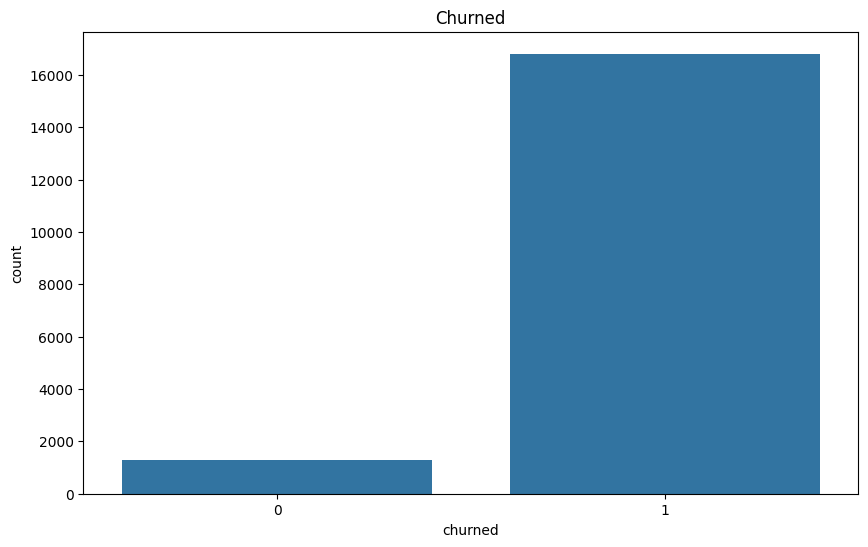

In [31]:
# plot value counts de churned
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_df, x='churned')
plt.title('Churned')
plt.show()


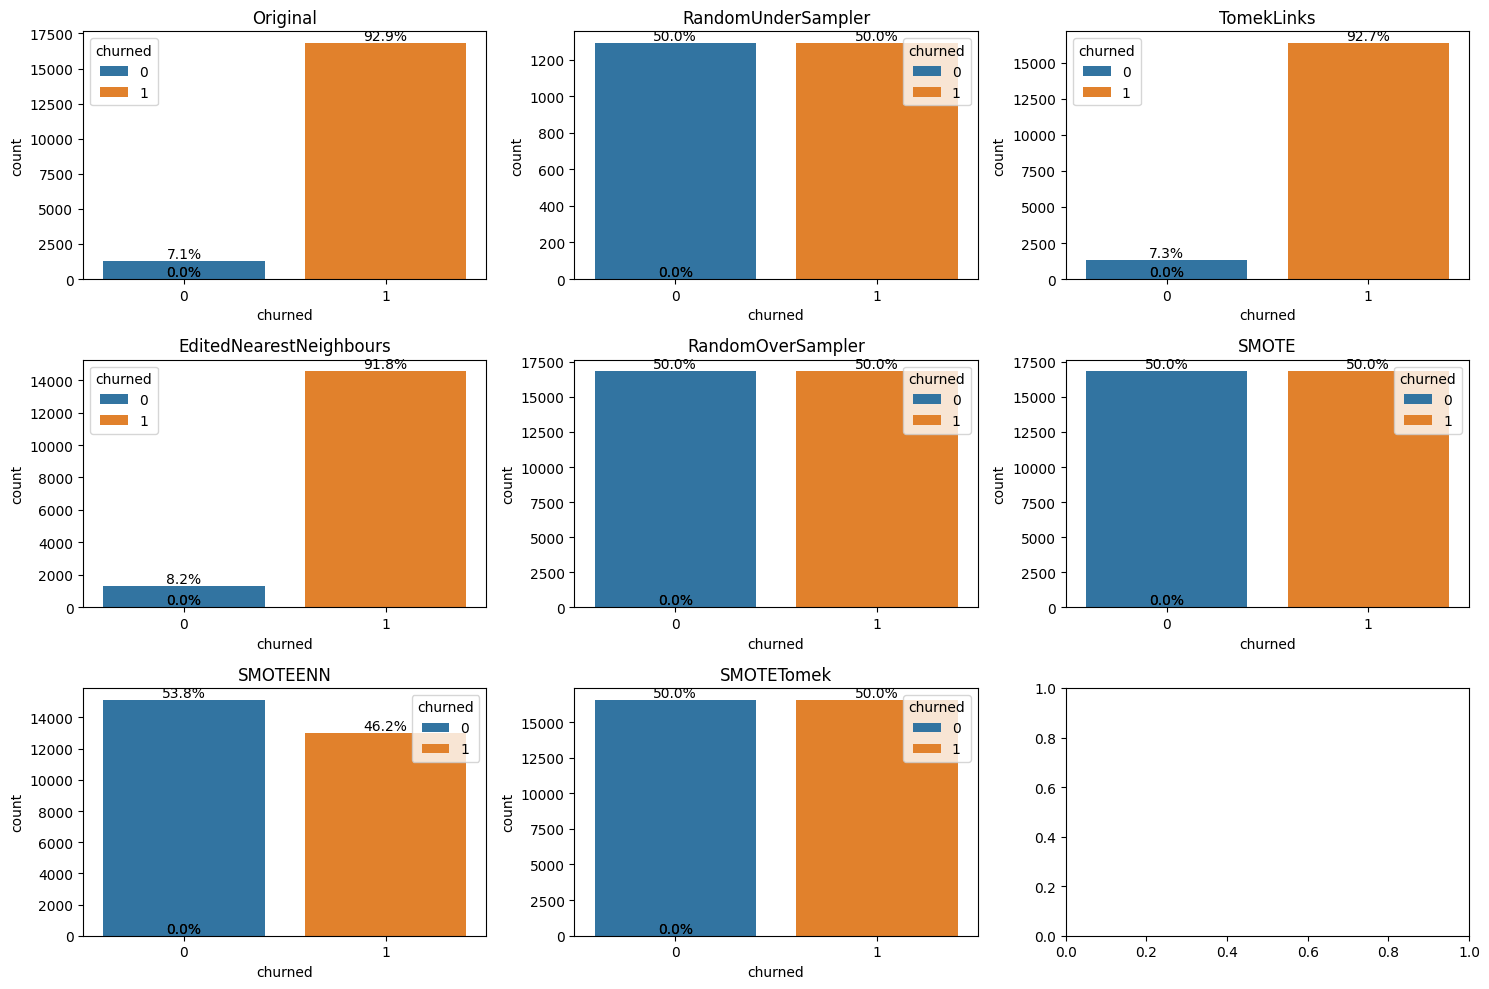

In [32]:
# balancing the dataset
models = [
    ('Original', clean_df),
    ('RandomUnderSampler', RandomUnderSampler(sampling_strategy='auto')),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('EditedNearestNeighbours', EditedNearestNeighbours(sampling_strategy='auto')),
    ('RandomOverSampler', RandomOverSampler(sampling_strategy='auto')),
    ('SMOTE', SMOTE(sampling_strategy='auto')),
    ('SMOTEENN', SMOTEENN(sampling_strategy='auto')),
    ('SMOTETomek', SMOTETomek(sampling_strategy='auto')),
]

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax = ax.ravel()

for i, (name, model) in enumerate(models):
    if name == 'Original':
        data = clean_df
    else:
        data = clean_df.copy()

        # fit the model
        Xr, yr = model.fit_resample(data.drop(columns='churned'), data['churned'])
        data = pd.concat([Xr, yr], axis=1)

    sns.countplot(data=data, x='churned', ax=ax[i], hue='churned')
    # annotate percentage
    total = len(data)
    for p in ax[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax[i].annotate(percentage, (x, y), ha='center', va='bottom')
    ax[i].set_title(name)

plt.tight_layout()
plt.show()


In [33]:
# # del analisis previo PCA sabemos que las variables que mas aportan a la varianza son:
# # 'win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet'
# # por lo que las usaremos para el modelo

# X = clean_df[['win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet']]
# y = clean_df['churned']

X, y = clean_df.drop(['churned'], axis=1), clean_df['churned']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12669, 17) (5430, 17) (12669,) (5430,)


In [35]:
def apply_box_cox(X):
    """
    Apply box-cox transformation to all variables in the dataset
    X: numpy.ndarray
    """
    X = X.copy()
    for i in range(X.shape[1]):
        X[:, i] = boxcox(X[:, i] + 1)[0]
    return X


In [36]:
# columns_to_transform = df.columns.drop(['churned', 'winner', 'days_since_registration', 'net_win']).tolist()
columns_to_transform = clean_df.columns.drop(['churned', 'winner', 'net_win']).tolist()
# other_columns = ['days_since_registration', 'net_win']
other_columns = ['net_win']


robust_pipe = Pipeline(
  steps = [
    ('RobustScaler', RobustScaler()),
    ('FunctionTransformer', FunctionTransformer(apply_box_cox))
  ]
)

power_transform_pipe = Pipeline(
  steps = [

    ('PowerTransformer', PowerTransformer())
  ]
)

preprocessor = ColumnTransformer(
  transformers = [
    ('robust_pipe', robust_pipe, columns_to_transform),
    # ('box_cox_pipe', box_cox_pipe, columns_to_transform),
    ('power_transform_pipe', power_transform_pipe, other_columns)
  ]
)

preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('robust_pipe',
                                 Pipeline(steps=[('RobustScaler',
                                                  RobustScaler()),
                                                 ('FunctionTransformer',
                                                  FunctionTransformer(func=<function apply_box_cox at 0x2b8c41940>))]),
                                 ['purchases_count', 'purchases_amount',
                                  'cashouts_count', 'cashouts_amount',
                                  'total_bets', 'winning_bets', 'losing_bets',
                                  'total_risk', 'total_win', 'net_winnings',
                                  'net_losses', 'win_ratio', 'risk_per_bet',
                                  'net_winnings_per_bet',
                                  'net_losses_per_bet']),
                                ('power_transform_pipe',
                                 Pipeline(steps=[('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['net_win'])])

In [37]:
Xt_train = preprocessor.transform(X_train)
Xt_test = preprocessor.transform(X_test)


In [38]:
Xt_train.shape, Xt_test.shape

((12669, 16), (5430, 16))

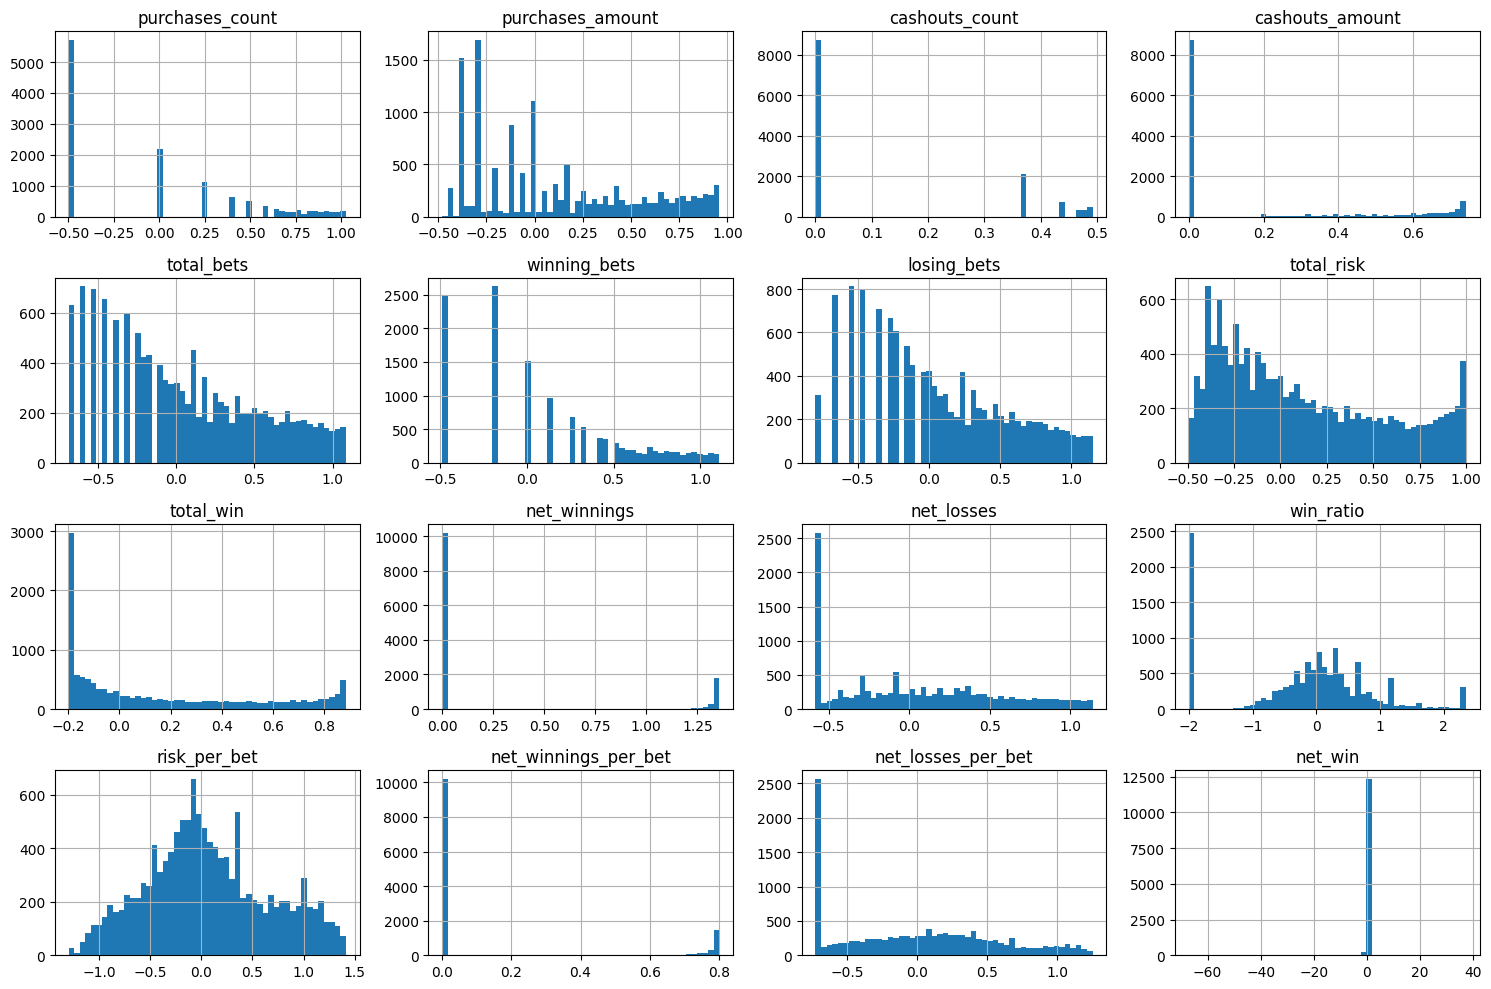

In [39]:
pd.DataFrame(Xt_train, columns=columns_to_transform+other_columns).hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [40]:
def get_models():
    models, names = list(), list()

    models.append(RandomUnderSampler())
    names.append('RandomUnderSampler')

    models.append(TomekLinks())
    names.append('TomekLinks')

    models.append(EditedNearestNeighbours())
    names.append('EditedNearestNeighbours')

    models.append(RandomOverSampler())
    names.append('RandomOverSampler')

    models.append(SMOTE())
    names.append('SMOTE')

    models.append(SMOTEENN())
    names.append('SMOTEENN')

    models.append(SMOTETomek())
    names.append('SMOTETomek')


    return models, names


In [41]:

modelos, nombres = get_models()
resultados = list()
confusion_matrices = list()

for i in range(len(modelos)):
    model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
    pipeline = make_pipeline(preprocessor, modelos[i], model)

    metrics = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'roc_auc':'roc_auc', 'gmean': make_scorer(geometric_mean_score)}

    scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=kfold, n_jobs=-1)
    # resultados.append(scores)

    print(f'{nombres[i]}')

    print('Accuracy: %.3f (%.3f)' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))
    print('Precision: %.3f (%.3f)' % (np.mean(scores['test_precision']), np.std(scores['test_precision'])))
    print('Recall: %.3f (%.3f)' % (np.mean(scores['test_recall']), np.std(scores['test_recall'])))
    print('ROC AUC: %.3f (%.3f)' % (np.mean(scores['test_roc_auc']), np.std(scores['test_roc_auc'])))
    print('G-Mean: %.3f (%.3f)' % (np.mean(scores['test_gmean']), np.std(scores['test_gmean'])))

    print('-----------------------------------')

    # imbalanced classification report
    print('Imbalanced classification report')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    confusion_matrices.append(
        (confusion_matrix(y_test, y_pred), confusion_matrix(y_test, y_pred, normalize='true'))
    )

    print(classification_report_imbalanced(y_test, y_pred, target_names=['no churn', 'churn']))

    print('-----------------------------------')




RandomUnderSampler
Accuracy: 0.493 (0.005)
Precision: 0.926 (0.006)
Recall: 0.493 (0.003)
ROC AUC: 0.492 (0.020)
G-Mean: 0.492 (0.020)
-----------------------------------
Imbalanced classification report
                   pre       rec       spe        f1       geo       iba       sup

   no churn       0.07      0.50      0.50      0.12      0.50      0.25       375
      churn       0.93      0.50      0.50      0.65      0.50      0.25      5055

avg / total       0.87      0.50      0.50      0.62      0.50      0.25      5430

-----------------------------------
TomekLinks
Accuracy: 0.863 (0.002)
Precision: 0.928 (0.001)
Recall: 0.924 (0.001)
ROC AUC: 0.501 (0.007)
G-Mean: 0.269 (0.023)
-----------------------------------
Imbalanced classification report
                   pre       rec       spe        f1       geo       iba       sup

   no churn       0.06      0.07      0.92      0.07      0.26      0.06       375
      churn       0.93      0.92      0.07      0.93      0.26

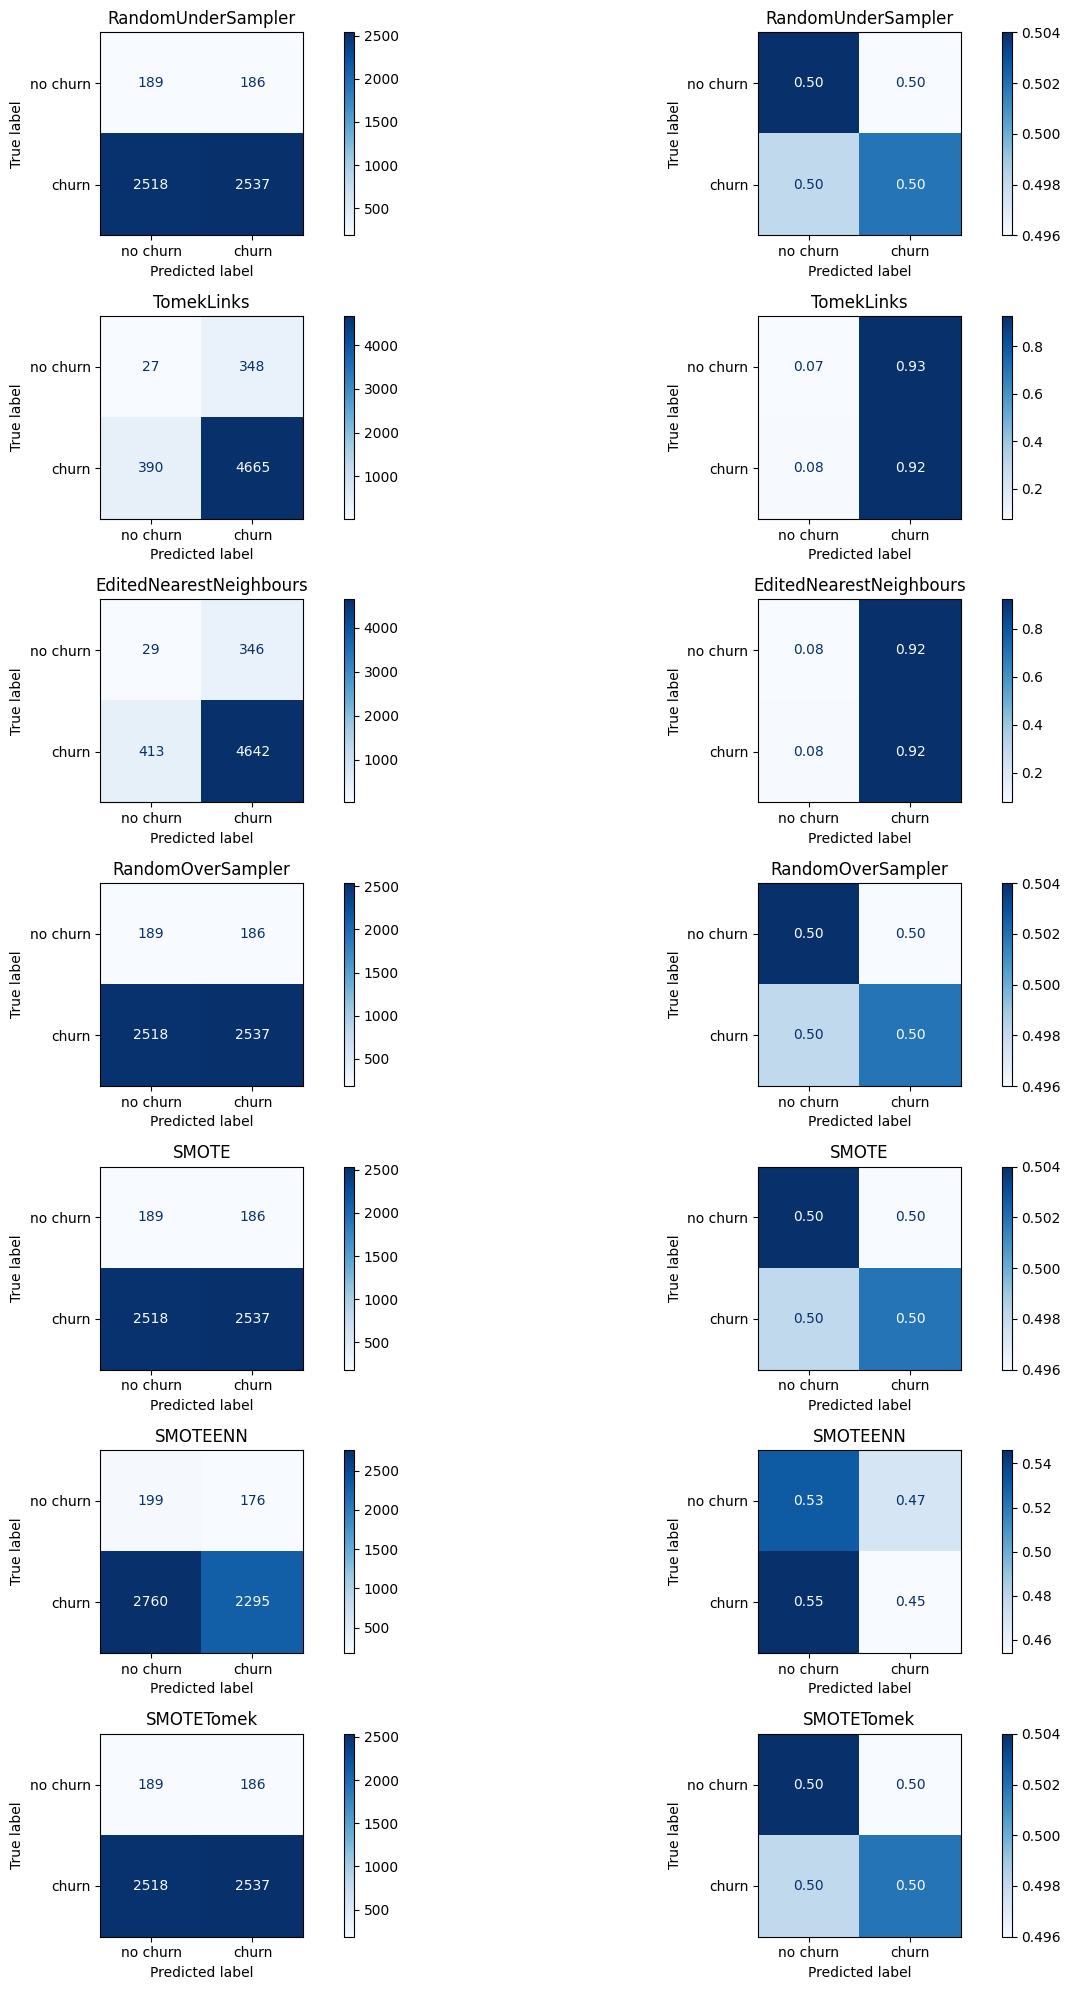

In [42]:
# number of models
n = len(confusion_matrices)
fig, axs = plt.subplots(n, 2, figsize=(15, 20))

for i in range(n):
    cm, cm_normalized = confusion_matrices[i]
    dip = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no churn', 'churn'])
    dip.plot(ax=axs[i, 0], cmap='Blues', values_format='.0f')

    dip = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no churn', 'churn'])
    dip.plot(ax=axs[i, 1], cmap='Blues', values_format='.2f')

    axs[i, 0].set_title(f'{nombres[i]}')
    axs[i, 1].set_title(f'{nombres[i]}')

plt.tight_layout()
plt.show()

El modelo más simple de clasificación que se puede utilizar es el modelo de regresión logística. Este modelo es un modelo lineal que se utiliza para clasificación binaria. La regresión logística es un modelo lineal generalizado que utiliza la función logística para modelar la probabilidad de que una instancia pertenezca a una clase en particular.

# Regresión Logística con Dataset Completo y Balanceo de clases

In [43]:
# ROC_AUC
# https://towardsdatascience.com/a-framework-for-analyzing-churn-370d2283b75c#179c

from sklearn.model_selection import GridSearchCV

base_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=100000)
# resampling = SMOTEENN(random_state=RANDOM_STATE)
resampling = SMOTETomek(random_state=RANDOM_STATE)
# resampling = TomekLinks()

pipeline = make_pipeline(preprocessor, resampling, base_model)

# grid search
grid = {
    'logisticregression__C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

# Best: 0.8593888121285692 using {'logisticregression__C': 0.95, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

Best: 0.8593888121285692 using {'logisticregression__C': 0.95, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.8389137955974474 (0.015744760080639835) with: {'logisticregression__C': 0.005, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.8392609865216857 (0.015712891249582597) with: {'logisticregression__C': 0.005, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
0.8409901565955035 (0.01643106740131816) with: {'logisticregression__C': 0.005, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.8407236249175422 (0.016536664733415085) with: {'logisticregression__C': 0.005, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
0.8401196984586268 (0.015430357470979452) with: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.8400341060450949 (0.015498757039853055) with: {'logisticregres

In [44]:
best_model = grid_result.best_estimator_

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred, target_names=['no churn', 'churn']))


                   pre       rec       spe        f1       geo       iba       sup

   no churn       0.23      0.83      0.80      0.36      0.81      0.66       375
      churn       0.98      0.80      0.83      0.88      0.81      0.66      5055

avg / total       0.93      0.80      0.82      0.85      0.81      0.66      5430



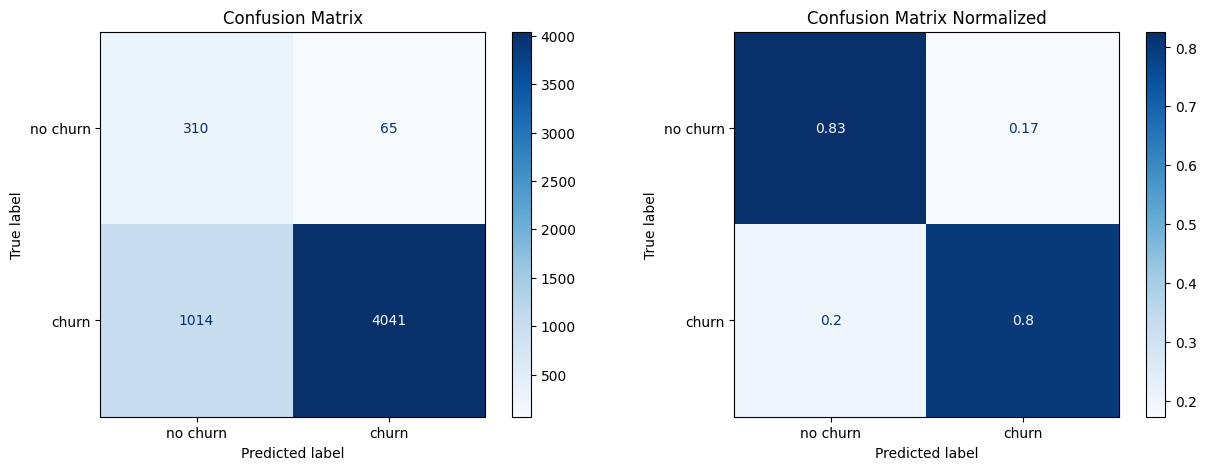

In [45]:
# confusion matrix

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize=None, ax=axs[0])
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize='true', ax=axs[1])

axs[0].set_title('Confusion Matrix')
axs[1].set_title('Confusion Matrix Normalized')
plt.show()

In [46]:
dummy_pipe = make_pipeline(preprocessor, resampling, DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
dummy_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robust_pipe',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler()),
                                                                  ('FunctionTransformer',
                                                                   FunctionTransformer(func=<function apply_box_cox at 0x2b8c41940>))]),
                                                  ['purchases_count',
                                                   'purchases_amount',
                                                   'cashouts_count',
                                                   'cashouts_amount',
                                                   'total_bets', 'winning_bets',
                                                   'losing_bets', 'total_risk',
                                                   'total_win', 'net_winnings',
                                                   'net_losses', 'win_ratio',
                                                   'risk_per_bet',
                                                   'net_winnings_per_bet',
                                                   'net_losses_per_bet']),
                                                 ('power_transform_pipe',
                                                  Pipeline(steps=[('PowerTransformer',
                                                                   PowerTransformer())]),
                                                  ['net_win'])])),
                ('smotetomek', SMOTETomek(random_state=42)),
                ('dummyclassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))])

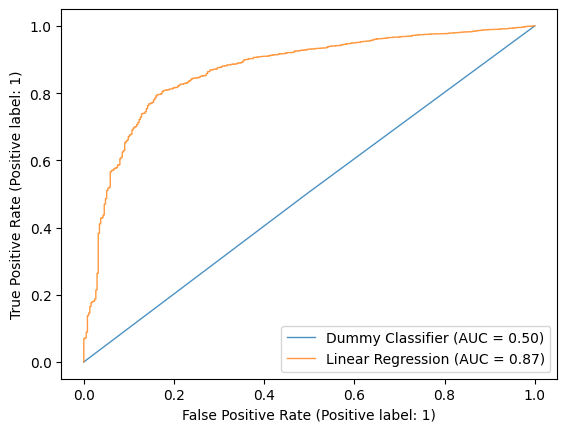

In [47]:
dummy_disp = RocCurveDisplay.from_estimator(dummy_pipe, X_test, y_test, name='Dummy Classifier', lw=1, alpha=0.8)
lin_reg_dip = RocCurveDisplay.from_estimator(best_model, X_test, y_test, name='Linear Regression', lw=1, alpha=0.8, ax=dummy_disp.ax_)
plt.show()




In [48]:
train_t = preprocessor.transform(X_train)
test_t = preprocessor.transform(X_test)

train_t = pd.DataFrame(train_t, columns=columns_to_transform + other_columns)
test_t = pd.DataFrame(test_t, columns=columns_to_transform + other_columns)

In [49]:
# resampling to balance the dataset
resampling = SMOTETomek(random_state=RANDOM_STATE)
train_r, yr = resampling.fit_resample(train_t, y_train)

train_r.shape, yr.shape


((23358, 16), (23358,))

In [50]:
yr.value_counts()

churned
1    11679
0    11679
Name: count, dtype: int64

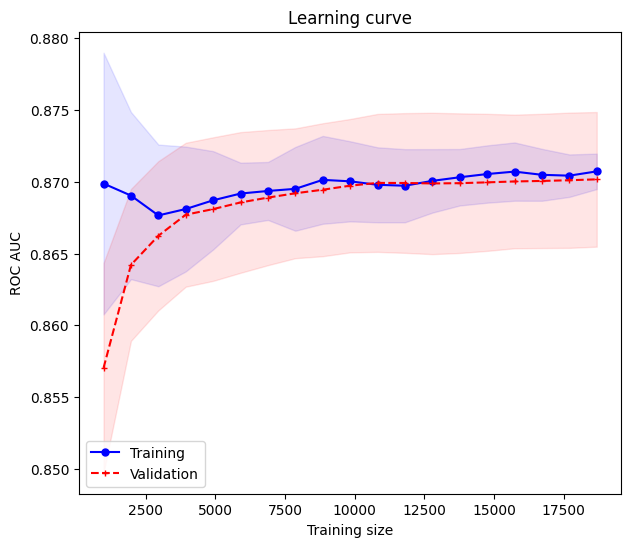

In [51]:
# Best: 0.8593888121285692 using {'logisticregression__C': 0.95, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

steps = np.linspace(0.0001, 1.0, 20)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

model = LogisticRegression(
    C=0.95,
    penalty='l1',
    solver='liblinear',
    random_state=RANDOM_STATE,
    max_iter=100000
)

train_sizes, train_scores, test_scores = learning_curve(
    model,
    train_r,
    np.ravel(yr),
    train_sizes=steps,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    shuffle=True
)

learning_curve_plot(train_sizes, train_scores, test_scores,
                    title='Learning curve',
                    xlabel='Training size',
                    ylabel='ROC AUC')

# evaluate_metrics(model, X_train, y_train, X_test, y_test, 'f1')

# Logistic Regression sin RESAMPLING

In [52]:
train_t = preprocessor.transform(X_train)
test_t = preprocessor.transform(X_test)

In [53]:
lg_model = LogisticRegression(max_iter=100000)

parameters = {'C' : [0.001, 0.01, 0.1, 1, 10],
              'penalty' : ['l2'],
              'solver' : ['newton-cg' 'lbfgs', 'liblinear', 'sag', 'saga'],
              'class_weight' : ['balanced', None]
              }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_lg = GridSearchCV(
    estimator=lg_model,
    param_grid=parameters,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

grid_lg.fit(train_t, np.ravel(y_train))

/Users/rodrigolopezaguilera/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rodrigolopezaguilera/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rodrigolopezaguilera/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rodrigolopezaguilera/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rodrigolopezaguilera/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=LogisticRegression(max_iter=100000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', None], 'penalty': ['l2'],
                         'solver': ['newton-cglbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(f1_score))

In [54]:
print(f'Best: {grid_lg.best_score_} using {grid_lg.best_params_}')

Best: 0.9625211466904384 using {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}


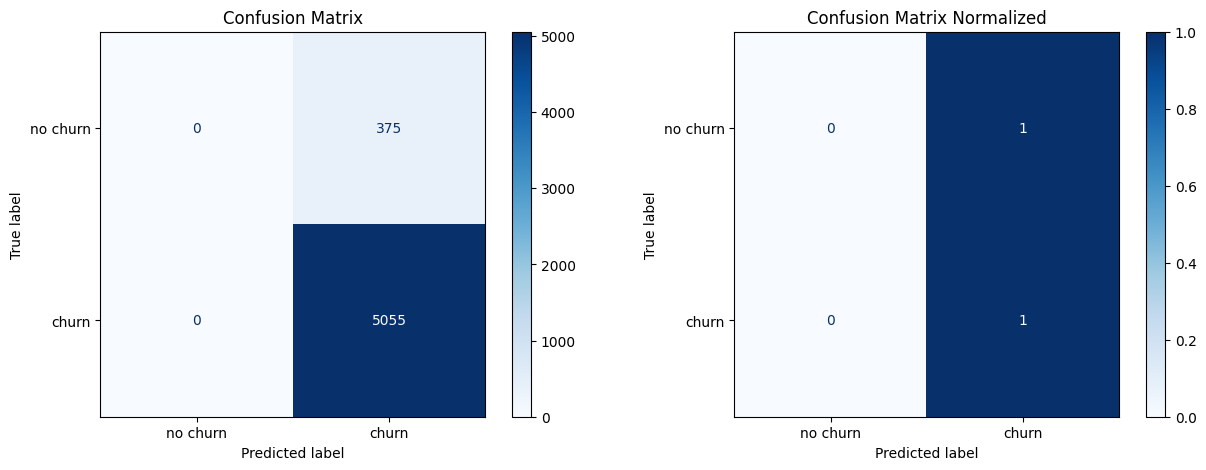

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(grid_lg, test_t, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize=None, ax=axs[0])
ConfusionMatrixDisplay.from_estimator(grid_lg, test_t, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize='true', ax=axs[1])

axs[0].set_title('Confusion Matrix')
axs[1].set_title('Confusion Matrix Normalized')
plt.show()

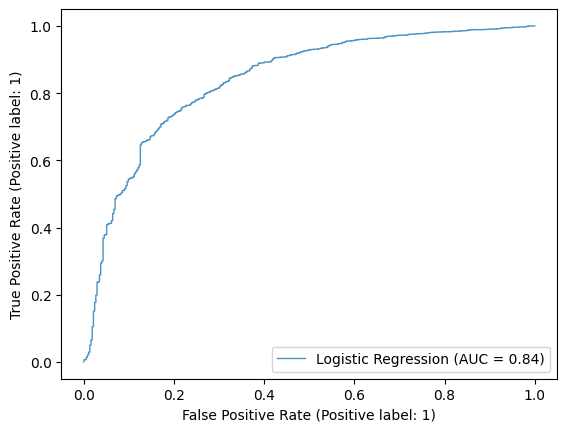

In [56]:
RocCurveDisplay.from_estimator(
    grid_lg.best_estimator_,
    test_t,
    y_test,
    name='Logistic Regression',
    lw=1,
    alpha=0.8
)
plt.show()

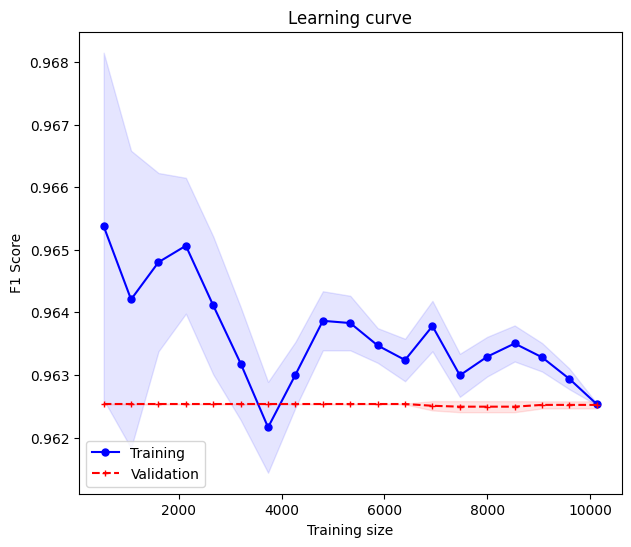

In [57]:
steps = np.linspace(0.0001, 1.0, 20)
model = LogisticRegression(max_iter=1000000, C=0.001, class_weight=None, penalty='l2', solver='sag')

train_sizes, train_scores, test_scores = learning_curve(
    model,
    train_t,
    np.ravel(y_train),
    train_sizes=steps,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1
)

learning_curve_plot(train_sizes, train_scores, test_scores,
                    title='Learning curve',
                    xlabel='Training size',
                    ylabel='F1 Score')

# evaluate_metrics(model, X_train, y_train, X_test, y_test, 'f1')

# Regresión Logística con los datos que indico PCA

In [58]:
# del análisis previo PCA sabemos que las variables que mas aportan a la varianza son:
# 'win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet'
# por lo que las usaremos para el modelo

X = clean_df[['win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet']]
y = clean_df['churned']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14479, 4) (3620, 4) (14479,) (3620,)


In [60]:
robust_pipe = Pipeline(
  steps = [
    ('RobustScaler', RobustScaler()),
    ('FunctionTransformer', FunctionTransformer(apply_box_cox)),

  ]
)

power_transform_pipe = Pipeline(
  steps = [
    ('PowerTransformer', PowerTransformer())
  ]
)

preprocessor = ColumnTransformer(
  transformers = [
    ('robust_pipe', robust_pipe, ['win_ratio', 'risk_per_bet', 'net_winnings_per_bet', 'net_losses_per_bet']),
    # ('box_cox_pipe', box_cox_pipe, columns_to_transform),
    # ('power_transform_pipe', power_transform_pipe, ['net_win'])
  ],
  remainder = 'passthrough'
)

preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('robust_pipe',
                                 Pipeline(steps=[('RobustScaler',
                                                  RobustScaler()),
                                                 ('FunctionTransformer',
                                                  FunctionTransformer(func=<function apply_box_cox at 0x2b8c41940>))]),
                                 ['win_ratio', 'risk_per_bet',
                                  'net_winnings_per_bet',
                                  'net_losses_per_bet'])])

In [61]:
base_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
resampling = SMOTEENN(random_state=RANDOM_STATE)
# resampling = TomekLinks()

pipeline = make_pipeline(preprocessor, resampling, base_model)

# grid search
grid = {
    'logisticregression__C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)


In [62]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.7330623967289837 using {'logisticregression__C': 0.04, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [63]:
best_model = grid_result.best_estimator_

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred, target_names=['no churn', 'churn']))

                   pre       rec       spe        f1       geo       iba       sup

   no churn       0.14      0.75      0.65      0.23      0.70      0.49       250
      churn       0.97      0.65      0.75      0.78      0.70      0.48      3370

avg / total       0.91      0.66      0.74      0.74      0.70      0.48      3620



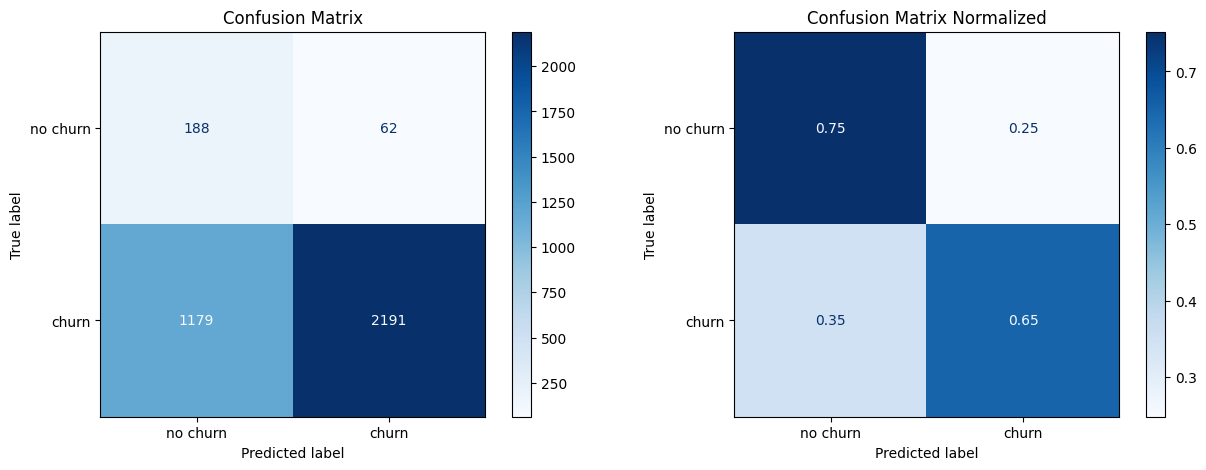

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize=None, ax=axs[0])
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['no churn', 'churn'], cmap='Blues', normalize='true', ax=axs[1])

axs[0].set_title('Confusion Matrix')
axs[1].set_title('Confusion Matrix Normalized')
plt.show()

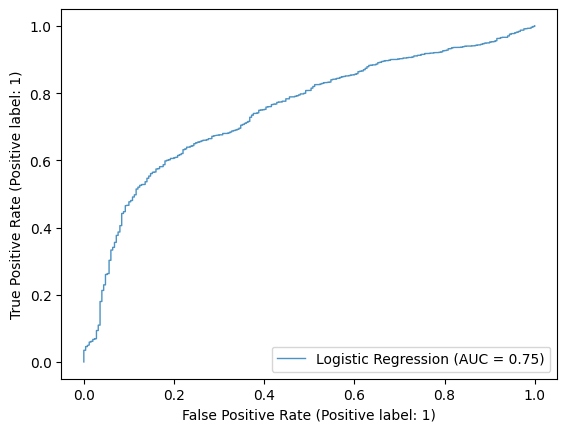

In [65]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name='Logistic Regression', lw=1, alpha=0.8)
plt.show()

## Conclusiones y justificación del proceso

### Justificación del algoritmo de Regresión Logística

Como el problema que se aborda es para predecir si un usuario hará o no churn, el problema se reduce a un problema de dos clases, 1 o 0. El algoritmo que se utilizó fue el de regresión logística por la simplicidad que ofrece el algoritmo, la cantidad de hiperparámetros a manejar no son demasiados para realizar una búsqueda exhaustiva con un **GridSearchCV** y poder analizar los resultados obtenidos. Si bien se utilizaron diferentes métricas para evaluar el algoritmo, los resultados fueron relativamente buenos para el algoritmo base escogido y esto permite que se puedan explorar otros modelos para descubrir si se puede mejorar el desempeño. De igual manera, el rendimiento del modelo es bueno y provee valor al caso de uso.

### Métricas

Se exploró diferentes técnicas para tratar de balancear las clases debido a la alta diferencia de proporción que hay entre ambas clases. Es importante destacar que en algunas particiones que se hacian al dataset resultó en sets de datos que no contenian rastro de ambas clases, solamente de la clase que más abunda. Esto puede que haya provocado un análisis incompleto al momento de evaluar las métricas para el modelo pero esta situacion no se presento por lo que podemos confiar en los resultados del análisis.

Se utilizaron diferentes métricas para evaluar los modelos, entre ellas:
- Precision
- Recall
- Accuracy
- F1-score
- G-Mean

Cada una de estas métricas nos provee información relevante sobre el modelo y diferentes exploraciones con diferentes métodos de muestreo para balancear ambas clases. Dependiendo del caso de uso que busque el cliente sera la métrica que se quierea maximizar puesto que para cada combinacion de técnicas y modelos hay un intercambio entre estas métricas.

### Sub/Sobre entrenammiento

Se utilizaron dos tipos de sets, uno de entrenamiento y uno de validacion para observar si el modelo estaba sobre-entranando o sub-entrenando el dataset. Con las curvas de aprendizaje para ambos sets se puede concluir que no hubo un sobre-entrenamiento ni sub-entrenamiento debido a la baja diferencia que hay entre las diferentes métricas que hay para ambos sets.

### Métrica de baseline

Como no existe un histórico sobre este problema para la empresa en particular con la que se esta trabajando el problema, no hay un 'baseline' para poder basarnos si el modelo ha hecho un buen trabajo o si provee algun tipo de valor. Con esto en mente podemos entonces tomar estos resultados y definirlos como nuestro 'baseline' para futuros análisis que se quieran hacer para este problema en específico y esto permitirá trabajar sobre estos resultados.